In [ ]:
# Uncomment this when running in a remote (e.g. Colab) environment
'''
!git clone https://github.com/dominicm00/plsn.git
%cd plsn
%pip install -e .
'''

# PLSN (Plastic Local Sparse Network)

This notebook demonstrates the PLSN architecture with spatially-positioned neurons and distance-based connectivity.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

from plsn import NetworkBuilder
from plsn.init import (
    DistanceBasedInitializer,
    LatticePositionInitializer,
    RandomPositionInitializer,
)
from plsn.init.distributions import (
    LinearDistanceDistribution,
    GaussianDistanceDistribution,
    ExponentialDistanceDistribution,
    StepDistanceDistribution,
)

## Create a Lattice Network

Build a 4×4 lattice of neurons with linear distance-based connections.

In [9]:
network = (
    NetworkBuilder()
    .with_dimensions(2)
    .with_neurons(16)  # 4x4 grid
    .with_bands(4)
    .with_position_initializer(LatticePositionInitializer())
    .with_connection_initializer(
        DistanceBasedInitializer(LinearDistanceDistribution())
    )
    .with_seed(42)
    .build()
)

print(network)

LatticeNetwork(neurons=16, dims=2, bands=4, connections=24)


## Visualize the Network

Plot neurons as points and their connections as lines.

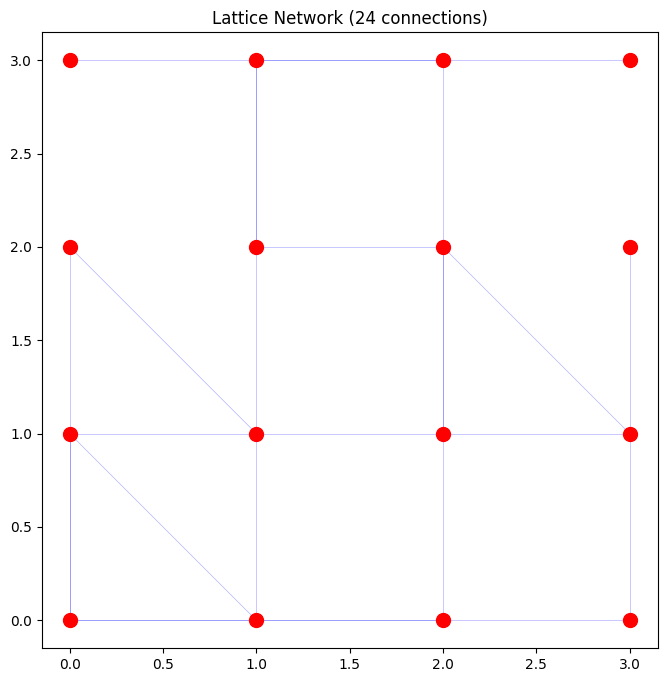

In [10]:
def visualize_network(net, ax=None, title="Lattice Network"):
    """Visualize a 2D lattice network."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Draw connections
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            p1 = net.neurons[i].position
            p2 = net.neurons[j].position
            ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                   'b-', alpha=0.3, linewidth=0.5)
    
    # Draw neurons
    positions = np.array([n.position for n in net.neurons])
    ax.scatter(positions[:, 0], positions[:, 1], 
              s=100, c='red', zorder=5)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    return ax

visualize_network(network, title=f"Lattice Network ({network.connection_count()} connections)")
plt.show()

## Compare Distribution Types

See how different probability distributions affect connectivity patterns.

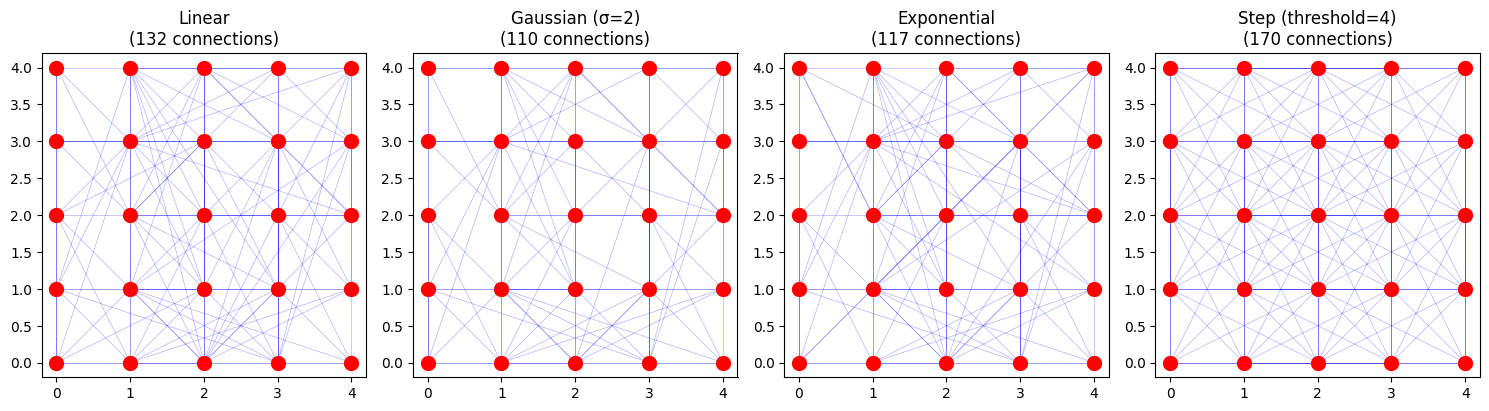

In [11]:
fig, axes = plt.subplots(1, 4, figsize=(15, 5))

distributions = [
    ("Linear", LinearDistanceDistribution(max_distance=6)),
    ("Gaussian (σ=2)", GaussianDistanceDistribution(sigma=2)),
    ("Exponential", ExponentialDistanceDistribution(scale=3)),
    ("Step (threshold=4)", StepDistanceDistribution(threshold=4)),
]

for ax, (name, dist) in zip(axes, distributions):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(25)
        .with_connection_initializer(DistanceBasedInitializer(dist))
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

# Compare Position Initializers

See how the networks look with different position initializers.

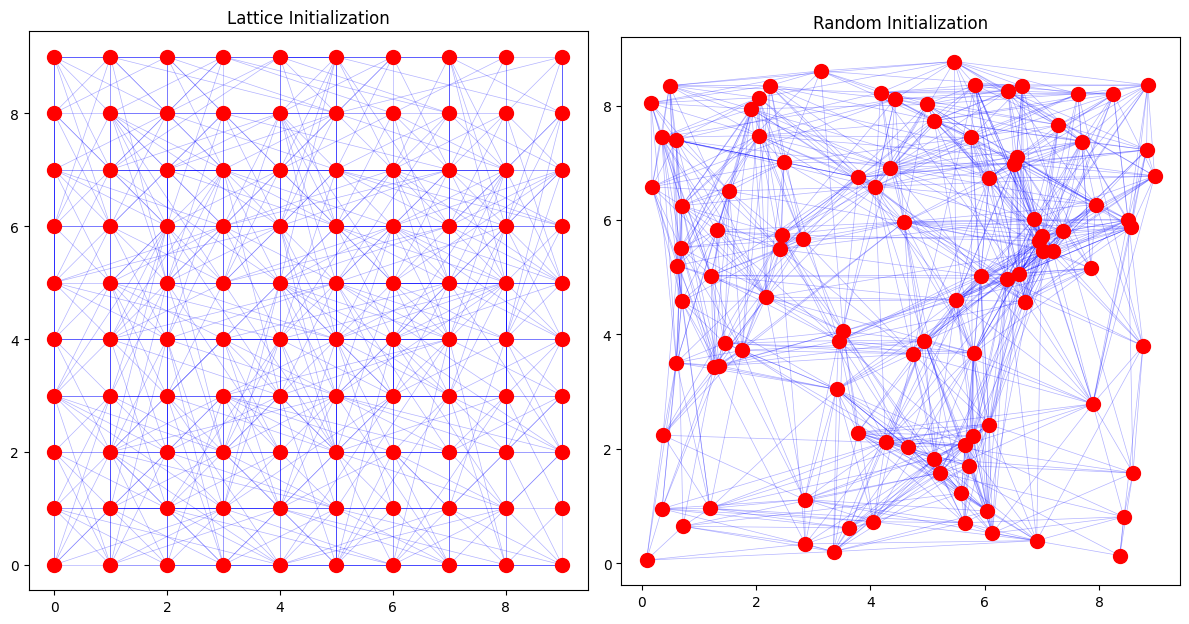

In [12]:
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

initializers = [
    ("Lattice", LatticePositionInitializer()),
    ("Random", RandomPositionInitializer()),
]

for ax, (name, init) in zip(axes, initializers):
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(100)
        .with_position_initializer(init)
        .with_connection_initializer(DistanceBasedInitializer(LinearDistanceDistribution(max_distance=6)))
        .with_seed(42)
        .build()
    )
    visualize_network(net, ax=ax, title=f"{name} Initialization")

plt.tight_layout()
plt.show()

## Global Initializer

The `GlobalInitializer` connects neurons with uniform probability regardless of distance.
This is useful for adding "small-world" long-range connections to locally-connected networks.

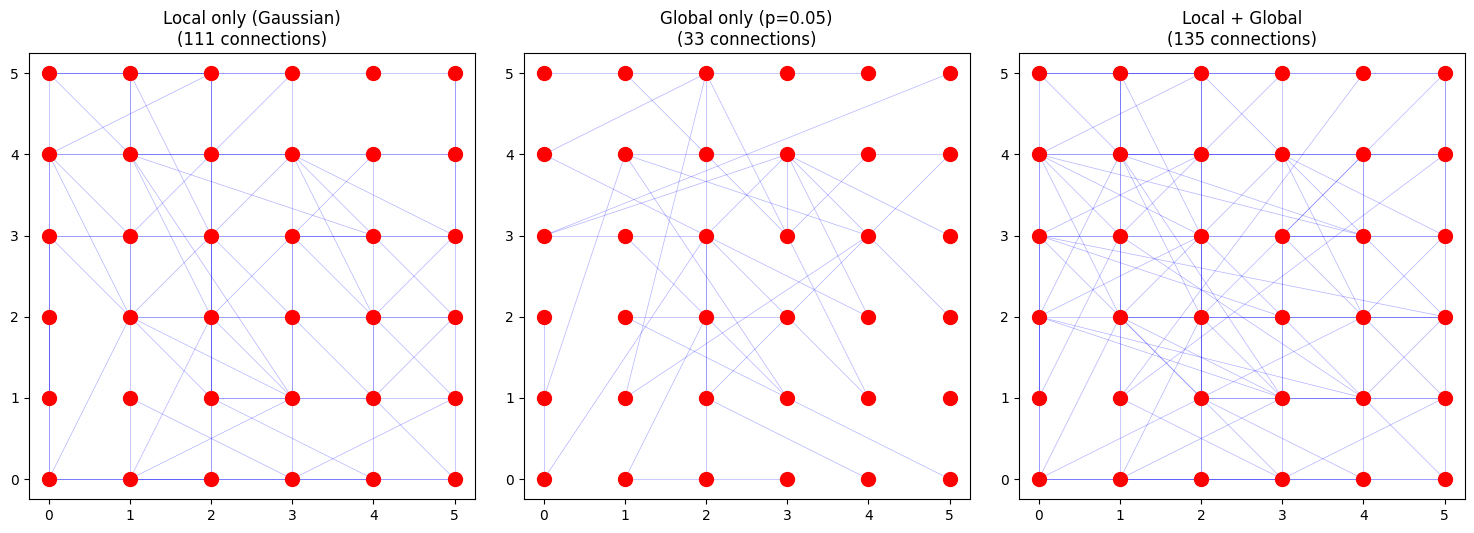

In [13]:
from plsn.init import GlobalInitializer

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

configs = [
    ("Local only (Gaussian)", [DistanceBasedInitializer(GaussianDistanceDistribution(sigma=1.5))]),
    ("Global only (p=0.05)", [GlobalInitializer(probability=0.05)]),
    ("Local + Global", [
        DistanceBasedInitializer(GaussianDistanceDistribution(sigma=1.5)),
        GlobalInitializer(probability=0.05),
    ]),
]

for ax, (name, inits) in zip(axes, configs):
    builder = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(36)
        .with_seed(42)
    )
    for init in inits:
        builder = builder.with_connection_initializer(init)
    net = builder.build()
    visualize_network(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()

## Weight Initialization

The `WeightInitializer` randomly assigns weights to existing connections based on a weight distribution.
This example shows connections color-coded by their weight values.

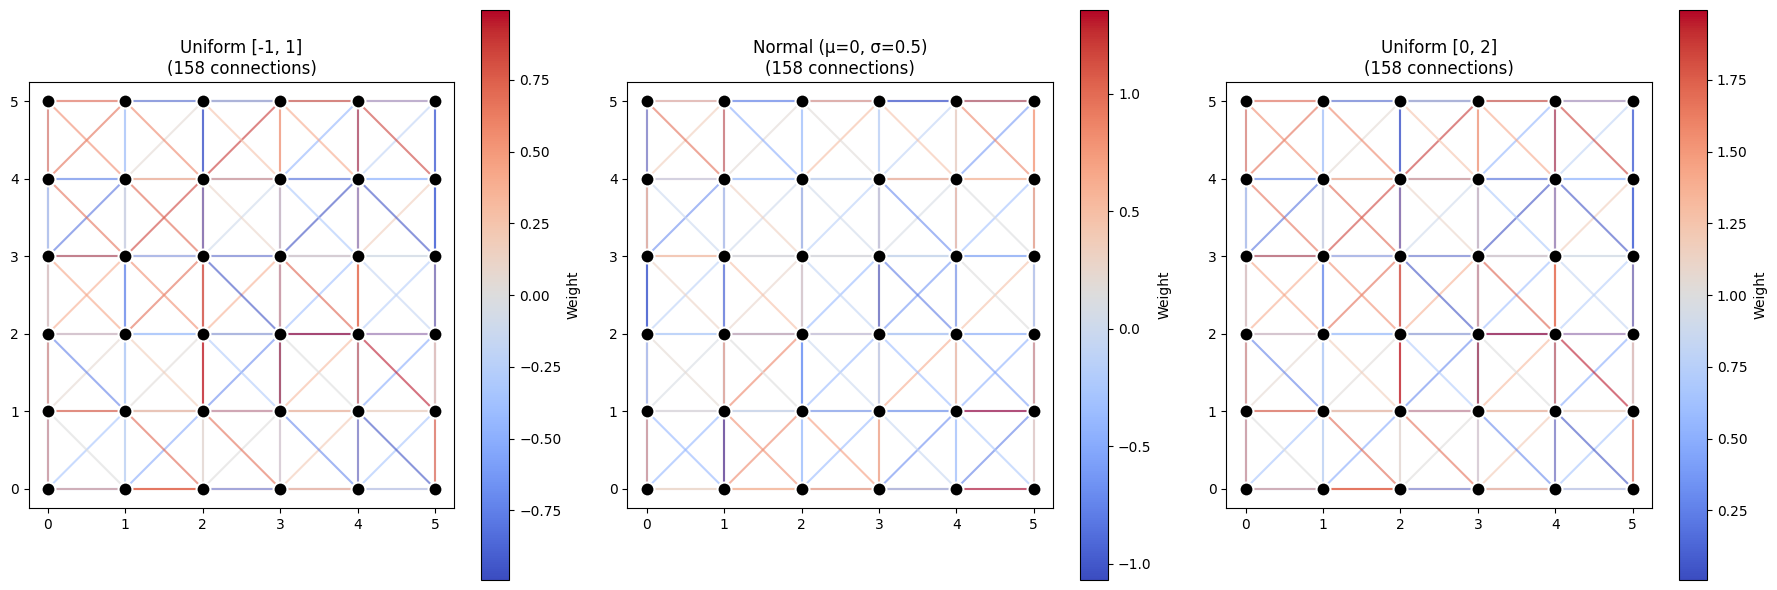

In [14]:
from plsn.init import WeightInitializer
from plsn.init.distributions import (
    UniformWeightDistribution,
    NormalWeightDistribution,
)
import matplotlib as mpl

def visualize_weights(net, ax=None, title="Weight-Coded Network", cmap='coolwarm'):
    """Visualize network with connections color-coded by weight."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 8))
    
    # Collect all weights for normalization
    all_weights = []
    for i in range(net.num_neurons):
        for j, w in net.get_outgoing(i):
            all_weights.append(w)
    
    if all_weights:
        vmin, vmax = min(all_weights), max(all_weights)
        norm = plt.Normalize(vmin=vmin, vmax=vmax)
        colormap = mpl.colormaps.get_cmap(cmap)
        
        # Draw connections with color based on weight
        for i in range(net.num_neurons):
            for j, w in net.get_outgoing(i):
                p1 = net.neurons[i].position
                p2 = net.neurons[j].position
                color = colormap(norm(w))
                ax.plot([p1[0], p2[0]], [p1[1], p2[1]], 
                       color=color, alpha=0.6, linewidth=1.5)
        
        # Add colorbar
        sm = mpl.cm.ScalarMappable(cmap=colormap, norm=norm)
        sm.set_array([])
        plt.colorbar(sm, ax=ax, label='Weight')
    
    # Draw neurons
    positions = np.array([n.position for n in net.neurons])
    ax.scatter(positions[:, 0], positions[:, 1], 
              s=100, c='black', zorder=5, edgecolors='white', linewidths=1.5)
    
    ax.set_title(title)
    ax.set_aspect('equal')
    return ax

# Create networks with different weight distributions
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

configs = [
    ("Uniform [-1, 1]", UniformWeightDistribution(-1.0, 1.0)),
    ("Normal (μ=0, σ=0.5)", NormalWeightDistribution(0.0, 0.5)),
    ("Uniform [0, 2]", UniformWeightDistribution(0.0, 2.0)),
]

for ax, (name, weight_dist) in zip(axes, configs):
    # Create network with connections
    net = (
        NetworkBuilder()
        .with_dimensions(2)
        .with_neurons(36)
        .with_connection_initializer(
            DistanceBasedInitializer(StepDistanceDistribution(threshold=3))
        )
        .with_connection_initializer(
            WeightInitializer(weight_dist)
        )
        .with_seed(42)
        .build()
    )
    visualize_weights(net, ax=ax, title=f"{name}\n({net.connection_count()} connections)")

plt.tight_layout()
plt.show()